In [2]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD


from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

In [3]:
import tensorflow as tf
print(tf.__version__)

2.11.0


<h3>Data Exploration</h3>

In [4]:
# set variables 
main_folder = "./archive/"
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000506.jpg'
EXAMPLE_PIC_2 = './example.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 200
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 5

In [5]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0


df_attr.shape

(202599, 40)

In [6]:
df_attr = df_attr.drop(columns=['5_o_Clock_Shadow',
'Arched_Eyebrows',
'Attractive',
'Bags_Under_Eyes',
'Bald',
'Bangs',
'Big_Lips',
'Big_Nose',
'Black_Hair',
'Blond_Hair',
'Blurry',
'Brown_Hair',
'Bushy_Eyebrows',
'Chubby',
'Double_Chin',
'Eyeglasses',
'Goatee',
'Gray_Hair',
'Heavy_Makeup',
'High_Cheekbones',
'Mouth_Slightly_Open',
'Mustache',
'Narrow_Eyes',
'No_Beard',
'Oval_Face',
'Pale_Skin',
'Pointy_Nose',
'Receding_Hairline',
'Rosy_Cheeks',
'Sideburns',
'Straight_Hair',
'Wavy_Hair',
'Wearing_Earrings',
'Wearing_Hat',
'Wearing_Lipstick',
'Wearing_Necklace',
'Wearing_Necktie'])


In [7]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print("'"+j+"',")

'Bald',
'Bangs',
'Big_Lips',
'Big_Nose',
'Black_Hair',
'Blond_Hair',
'Brown_Hair',
'Chubby',
'Eyeglasses',
'Gray_Hair',
'Heavy_Makeup',
'High_Cheekbones',
'Male',
'Mouth_Slightly_Open',
'Mustache',
'No_Beard',
'Oval_Face',
'Pale_Skin',
'Smiling',
'Straight_Hair',
'Wavy_Hair',
'Wearing_Lipstick',
'Young',


Smiling    1
Male       0
Young      1
Name: 000506.jpg, dtype: int64

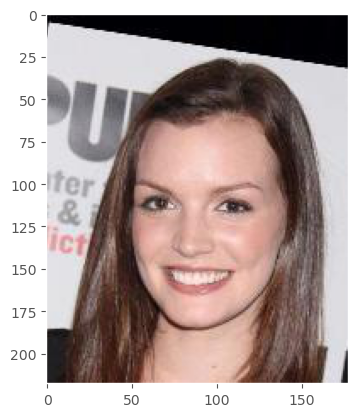

In [8]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

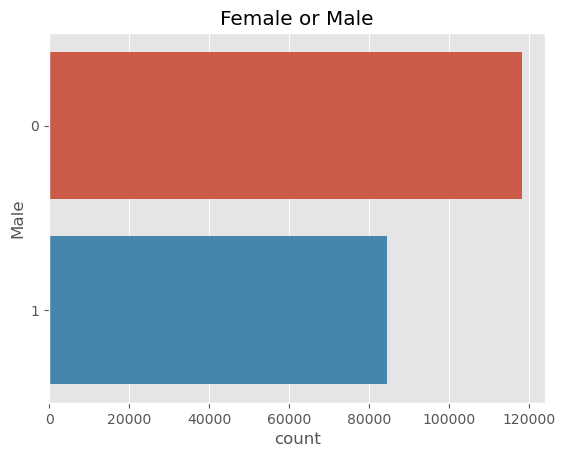

In [9]:
# Distribution of the Attribute
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr)
plt.show()

<h3>Step 2: Split Dataset into Training, Validation and Test</h3>

In [10]:
# Recomended partition
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [11]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [12]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_attr.join(df_partition['partition'], how='inner')
df_par_attr.head()

,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Brown_Hair,Chubby,Eyeglasses,Gray_Hair,...,Mustache,No_Beard,Oval_Face,Pale_Skin,Smiling,Straight_Hair,Wavy_Hair,Wearing_Lipstick,Young,partition
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,1,0,1,1,0
000002.jpg,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
000003.jpg,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
000004.jpg,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
000005.jpg,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0


<h3>2.1: Generate Partitions (Train, Validation, Test)</h3>

In [13]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition)].sample(num_samples)

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], IMG_HEIGHT, IMG_WIDTH, 3)
        y_ = np.array(df_.drop(['partition'], axis=1))
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
        y_ = np.array(df_.drop(['partition'], axis=1))
            
    return x_, y_

In [14]:
x,y = generate_df(0, TRAINING_SAMPLES)

KeyboardInterrupt: 

In [ ]:
x1,y1 = generate_df(1, TRAINING_SAMPLES)

In [ ]:
x2,y2 = generate_df(2, TRAINING_SAMPLES)

In [ ]:
y2.shape

In [ ]:
df_par_attr[(df_par_attr['partition'] == 0)].shape

<h3>Step 3: Pre-processing Images: Data Augmentation</h3>

In [ ]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(IMG_HEIGHT, IMG_WIDTH, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [ ]:
""""The result is a new set of images with modifications from the original one, 
that allows to the model to learn from these variations in order to take 
this kind of images during the learning process and predict better never 
seen images."""

In [ ]:
#3.2. Build Data Generators

# Train data
x_train, y_train = generate_df(0, TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [ ]:
# Validation Data
x_valid, y_valid = generate_df(1, VALIDATION_SAMPLES)

'''
# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)
'''

In [ ]:

x_test, y_test = generate_df(2, TEST_SAMPLES)

<h3>Step 4: Build the Model - Gender Recognition</h3>

In [ ]:
#4.1. Set the Model

# Import InceptionV3 Model
inc_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

In [ ]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(len(df_attr.columns), activation="sigmoid")(x)

In [ ]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [ ]:
# 4.2. Train Model

#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

In [ ]:
hist = model_.fit(x = x_train
                  , y = y_train
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

In [ ]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

In [ ]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

<h3>4.3. Model Evaluation</h3>

In [ ]:
#load the best model
model_.load_weights('weights.best.inc.male.hdf5')

# Test Data
x_test, y_test = generate_df(2, TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
# print('f1_score:', f1_score(y_test, model_predictions))


In [ ]:
import keras.utils as image

In [ ]:
def gender_prediction(filename):
    '''
    predict the gender
    
    input:
        filename: str of the file name
        
    return:
        array of the prob of the targets.
    
    '''
    '''
    img = image.load_img(filename, target_size=(200,200,3))

    img = image.img_to_array(img)
    img = img/255.
    plt.imshow(img)
    '''
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result

In [ ]:
#select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(1)

for index, target in df_to_test.iterrows():
    result = gender_prediction(images_folder + index)
    print(result)
    
# display result

In [ ]:
def resize_image(filename):
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_HEIGHT, IMG_WIDTH)).astype(np.float32) / 255.0
    return im


def display_image(image,result):
    s=""
    for i, label in enumerate(df_attr.columns):
        pred = result[0][i]
        s += f"{label}: predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})"
        s +="\n"
    plt.imshow(image)
    plt.title(s)
    plt.figure()
    return s   
img_path = './celia.jpg'
result = gender_prediction(img_path)
im = resize_image(img_path)
display_image(im,result)